# Do Batters Affect How Pitchers Throw?
### Based on MLB statcast data from the first half of 2024

##### This report is compromised of 2 main parts
1. Proving that a pitchers pitch type is not dependent on how many times he has thrown the ball during the plate appearance.
    - I.E. is a pitcher just as likely to throw a fast ball in his 4th ball with this batter as he is with his first

<br>

2. Finding a subset of all batters with an average of at least 3.1 plate appearances per game
   - When finding which batters to collect batting data from, we will only want to select batters who are on the plate enough to not be considered a rare batter. The MLB requires an average of 3.1 plate appearances for a player to be elible for certain batting awards, so we have chosen this as our requirement

_________________________________________________

### Imports and data reading

In [148]:
import pandas as pd
import seaborn as sns
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
from statistics import mean

In [149]:
bdf = pd.read_csv('statcast_pitch_swing_data_20240402_20240630.csv')
sns.set_theme(style='darkgrid')

____________________________________________________________________

## Preparation: Reclassify small amounts to be able to conduct hypothesis testing
In preparing for the chi-square test in the next section, I found quite a few values that have too low of expecte values to run an effective independance test. I will load the observed values and expected values below to show the proportions. To deal with this, I will be combining the infrequently used pitch numbers into one category, as well as the rarely used pitches.

In selecting the data, I drop around 250 rows with no information for pitch type. This data is miniscule and would not prove useful when analyzing pitch type usage.

In [152]:
bdf_pitch = bdf[['pitch_number', 'pitch_name']].dropna(axis='index')   #Select relevant info, drop empty rows
pitch_names = list(bdf_pitch['pitch_name'].unique())     #gather all unique pitch names to parse through later
pitch_nums = [i for i in range(1,15)]                     #create list of all pitcher numbers as it gets interated through multiple times
obs_pitch_df = pd.DataFrame(index=pd.Series(pitch_nums), columns=pitch_names)
for num in pitch_nums:      
    for name in pitch_names:           #Iterate through each pitch name and number and filling it with the count of pitches with those parameters
        obs_pitch_df.loc[num, name] = len(bdf_pitch[(bdf_pitch['pitch_number']==num)&(bdf_pitch['pitch_name']==name)])

obs_pitch_df = obs_pitch_df
obs_pitch_df

,4-Seam Fastball,Changeup,Sinker,Knuckle Curve,Slider,Sweeper,Cutter,Curveball,Slurve,Split-Finger,Pitch Out,Forkball,Other,Knuckleball,Eephus,Slow Curve
1,28746,5771,16962,1441,14041,4792,8230,6952,354,1476,9,19,89,143,57,1
2,22566,9686,12948,1104,12971,4545,7081,4593,268,2666,7,27,71,143,44,0
3,19707,7861,9459,1093,11019,4015,4967,4132,188,2562,3,20,55,116,27,1
4,16185,5362,6642,873,8502,3063,3401,3120,155,1919,0,14,38,73,15,0
5,10824,3449,4979,587,5512,1962,2151,2039,99,1282,0,10,22,63,12,0
6,6108,1940,2818,256,2976,1007,1395,1060,60,622,0,8,9,22,6,1
7,2571,787,1212,105,1235,408,596,394,20,229,0,2,2,13,3,0
8,1012,300,472,42,490,141,241,171,11,104,0,1,2,1,2,0
9,395,105,179,15,191,49,86,74,3,39,0,1,0,2,0,0
10,151,34,76,5,67,18,32,24,1,13,1,0,0,0,0,0


In [153]:
exp_pitch_df = pd.DataFrame(index=pd.Series(pitch_nums), columns=pitch_names)
for name in pitch_names:
    for num in pitch_nums:   #for each pitch name and number, set the expected value as the total occurance of that pitch multiplied by the % of the pitches that had the corresponding pitch number
        exp_pitch_df.loc[num, name] = ((len(bdf_pitch[bdf_pitch['pitch_number']==num])) * (len(bdf_pitch[bdf_pitch['pitch_name']==name])))/len(bdf_pitch)

exp_pitch_df = exp_pitch_df
exp_pitch_df

,4-Seam Fastball,Changeup,Sinker,Knuckle Curve,Slider,Sweeper,Cutter,Curveball,Slurve,Split-Finger,Pitch Out,Forkball,Other,Knuckleball,Eephus,Slow Curve
1,27895.337335,9092.902633,14358.84078,1422.238416,14681.702289,5152.653408,7260.2645,5811.764621,298.402303,2811.521272,5.149306,26.261462,74.150012,148.300023,42.739243,0.772396
2,24650.280694,8035.127861,12688.480925,1256.789827,12973.784046,4553.246705,6415.68,5135.683699,263.689249,2484.457803,4.550289,23.206474,65.524162,131.048324,37.767399,0.682543
3,20424.473555,6657.662789,10513.28974,1041.337861,10749.683237,3772.681864,5315.8375,4255.27146,218.484899,2058.546243,3.770231,19.228179,54.291329,108.582659,31.292919,0.565535
4,15457.153908,5038.490618,7956.412543,788.080023,8135.314127,2855.149439,4023.003,3220.371173,165.348434,1557.89896,2.853295,14.551803,41.087445,82.17489,23.682347,0.427994
5,10330.759786,3367.465743,5317.653382,526.711803,5437.221919,1908.233766,2688.7665,2152.329026,110.510315,1041.218844,1.906994,9.725671,27.460717,54.921434,15.828052,0.286049
6,5726.681064,1866.697387,2947.750751,291.973734,3014.031538,1057.796948,1490.472,1193.107006,61.259514,577.181965,1.05711,5.39126,15.222382,30.444763,8.774012,0.158566
7,2372.652145,773.401471,1221.298526,120.969214,1248.759676,438.261564,617.5255,494.322604,25.38076,239.135376,0.437977,2.233682,6.306867,12.613734,3.635208,0.065697
8,936.284798,305.19604,481.943064,47.736301,492.779653,172.944711,243.685,195.067254,10.015636,94.366474,0.172832,0.881445,2.488786,4.977572,1.434509,0.025925
9,356.665012,116.260298,183.589682,18.184497,187.717734,65.880945,92.8285,74.308228,3.815321,35.94763,0.065838,0.335775,0.948069,1.896139,0.546457,0.009876
10,132.144543,43.074491,68.020058,6.737364,69.549503,24.408919,34.393,27.531231,1.413578,13.318613,0.024393,0.124405,0.35126,0.70252,0.202462,0.003659


### 1. Lump together all rarely used pitches
The pitch type seems to have a few pitches that have extremely low usage, which could cause skew in hypothesis testing (see Slow Curve as the worst example). This could mean it is fundamentally different than the others. Pitches like 'Pitch Out' are used rarely and not a typical pitch, so it also useful to have it not be considered on its own. Lets see which pitches are used infrequently enough to group together as just 'Rare Pitch Types'.

In [155]:
pitchprob_df = pd.DataFrame(index=pitch_names, columns=['probability'])

for name in pitch_names: #For each pitch type, find its percent usage using the count of the pitch divided by total pitches
    pitchprob_df.loc[name, 'probability'] = round(len(bdf_pitch[bdf_pitch['pitch_name']==name])/len(bdf_pitch),4)

pitchprob_df = pitchprob_df.sort_values(by='probability') #sort, having lowest values at the top
print(f'The sum of the probabilities of all pitches with less than 0.01 usage is {pitchprob_df[pitchprob_df['probability']<0.01].sum().iloc[0]} ')
pitchprob_df

The sum of the probabilities of all pitches with less than 0.01 usage is 0.0067 


,probability
Slow Curve,0.0
Pitch Out,0.0001
Forkball,0.0003
Eephus,0.0005
Other,0.0008
Knuckleball,0.0017
Slurve,0.0033
Knuckle Curve,0.016
Split-Finger,0.0316
Sweeper,0.0578


All together, the pitches that are used less than 1% of the time make up only 0.67% of all of the pitches. I am comfortable grouping these pitches together under 'Rare Pitch' to make testing easier. If a correlation or discrepancy is found with this group later on, they can be ungrouped and tested again.

Now, I will need to reclassify the 7 pitches that are used less than 1% of the time as rare pitches. These are Slow Cureve, Pitch Out, Forkball, Eephus, other, Knuckleball, and Slurve

In [157]:
rare_pitches = ['Slow Curve', 'Pitch Out', 'Forkball', 'Eephus', 'Other', 'Knuckleball', 'Slurve']

for name in rare_pitches:  #replace the pitches above with 'Rare Pitch' in the data frame.
    bdf_pitch['pitch_name'] = bdf_pitch['pitch_name'].mask(bdf_pitch['pitch_name']==name, 'Rare Pitch')

#### Now, we can see the new observed and expected dataset with the 'Rare Pitch' category

In [159]:
pitch_names = list(bdf_pitch['pitch_name'].unique())     #gather all unique pitch names after reclassification
obs_pitch_df = pd.DataFrame(index=pd.Series(pitch_nums), columns=pitch_names)
for num in pitch_nums:
    for name in pitch_names:   #repeat observed values calculation
        obs_pitch_df.loc[num, name] = len(bdf_pitch[(bdf_pitch['pitch_number']==num)&(bdf_pitch['pitch_name']==name)])

obs_pitch_df = obs_pitch_df
obs_pitch_df

,4-Seam Fastball,Changeup,Sinker,Knuckle Curve,Slider,Sweeper,Cutter,Curveball,Rare Pitch,Split-Finger
1,28746,5771,16962,1441,14041,4792,8230,6952,672,1476
2,22566,9686,12948,1104,12971,4545,7081,4593,560,2666
3,19707,7861,9459,1093,11019,4015,4967,4132,410,2562
4,16185,5362,6642,873,8502,3063,3401,3120,295,1919
5,10824,3449,4979,587,5512,1962,2151,2039,206,1282
6,6108,1940,2818,256,2976,1007,1395,1060,106,622
7,2571,787,1212,105,1235,408,596,394,40,229
8,1012,300,472,42,490,141,241,171,17,104
9,395,105,179,15,191,49,86,74,6,39
10,151,34,76,5,67,18,32,24,2,13


In [160]:
exp_pitch_df = pd.DataFrame(index=pd.Series(pitch_nums), columns=pitch_names)
for name in pitch_names:
    for num in pitch_nums:  #repeat expected values calculation
        exp_pitch_df.loc[num, name] = len(bdf_pitch[bdf_pitch['pitch_number']==num])*(len(bdf_pitch[bdf_pitch['pitch_name']==name])/len(bdf_pitch))

exp_pitch_df = exp_pitch_df
exp_pitch_df

,4-Seam Fastball,Changeup,Sinker,Knuckle Curve,Slider,Sweeper,Cutter,Curveball,Rare Pitch,Split-Finger
1,27895.337335,9092.902633,14358.84078,1422.238416,14681.702289,5152.653408,7260.2645,5811.764621,595.774746,2811.521272
2,24650.280694,8035.127861,12688.480925,1256.789827,12973.784046,4553.246705,6415.68,5135.683699,526.468439,2484.457803
3,20424.473555,6657.662789,10513.28974,1041.337861,10749.683237,3772.681864,5315.8375,4255.27146,436.215751,2058.546243
4,15457.153908,5038.490618,7956.412543,788.080023,8135.314127,2855.149439,4023.003,3220.371173,330.126208,1557.89896
5,10330.759786,3367.465743,5317.653382,526.711803,5437.221919,1908.233766,2688.7665,2152.329026,220.639231,1041.218844
6,5726.681064,1866.697387,2947.750751,291.973734,3014.031538,1057.796948,1490.472,1193.107006,122.307607,577.181965
7,2372.652145,773.401471,1221.298526,120.969214,1248.759676,438.261564,617.5255,494.322604,50.673925,239.135376
8,936.284798,305.19604,481.943064,47.736301,492.779653,172.944711,243.685,195.067254,19.996705,94.366474
9,356.665012,116.260298,183.589682,18.184497,187.717734,65.880945,92.8285,74.308228,7.617474,35.94763
10,132.144543,43.074491,68.020058,6.737364,69.549503,24.408919,34.393,27.531231,2.822277,13.318613


### 2. Lump rare pitch numbers together

In the same vain as the pitch types, some pitch numbers are rarely used and could cause skew in a chi-square test. Using the new dataset made just above, the datafalls off around pitch 10. Values after that get below the 5 needed for chi-square testing quite often. Lets see how frequency of each pitch number to get a better idea of how rare they are

In [162]:
pitchnum_prob = pd.DataFrame(index=pitch_nums, columns=['probability'])  #create dataframe for pitch number probabilities

for num in pitch_nums:  #find % usage of each pitch number
    pitchnum_prob.loc[num, 'probability'] = round(len(bdf_pitch[bdf_pitch['pitch_number']==num])/len(bdf_pitch),4)

pitchnum_prob = pitchnum_prob.sort_values(by='probability') #descending sort
print(f'Pitches with a pitch number over 10 take up {pitchnum_prob.loc[[i for i in range(11,15)]].sum().iloc[0]}% of the data')
pitchnum_prob

Pitches with a pitch number over 10 take up 0.0007000000000000001% of the data


,probability
14,0.0
13,0.0001
12,0.0002
11,0.0004
10,0.0012
9,0.0033
8,0.0086
7,0.0219
6,0.0529
5,0.0953


Pitch numbers 11 through 14 take up just about 0.07% of the data. I will be reclassifying them as '>10'. They will get the same treatment as the rare pitches. If a trend is shown with these pitch numbers, they can be seperated and analyzed at that point.

Now, each of these rare pitch numbers will be grouped under '>10'

In [164]:
for num in range(11,15):  #replace all pitch numbers over 10 with '>10'
    bdf_pitch['pitch_number'] = bdf_pitch['pitch_number'].mask(bdf_pitch['pitch_number']==num, '>10')

Now, we can see the final combined observed and expected values to be used in the independance test

In [166]:
pitch_nums = list(bdf_pitch['pitch_number'].unique())    #create list of pitch numbers are reclassification
obs_pitch_df = pd.DataFrame(index=pd.Series(pitch_nums), columns=pitch_names)
for num in pitch_nums:
    for name in pitch_names: #repeat observed value calculations
        obs_pitch_df.loc[num, name] = len(bdf_pitch[(bdf_pitch['pitch_number']==num)&(bdf_pitch['pitch_name']==name)])

obs_pitch_df

,4-Seam Fastball,Changeup,Sinker,Knuckle Curve,Slider,Sweeper,Cutter,Curveball,Rare Pitch,Split-Finger
3,19707,7861,9459,1093,11019,4015,4967,4132,410,2562
2,22566,9686,12948,1104,12971,4545,7081,4593,560,2666
1,28746,5771,16962,1441,14041,4792,8230,6952,672,1476
4,16185,5362,6642,873,8502,3063,3401,3120,295,1919
8,1012,300,472,42,490,141,241,171,17,104
6,6108,1940,2818,256,2976,1007,1395,1060,106,622
5,10824,3449,4979,587,5512,1962,2151,2039,206,1282
7,2571,787,1212,105,1235,408,596,394,40,229
9,395,105,179,15,191,49,86,74,6,39
10,151,34,76,5,67,18,32,24,2,13


In [167]:
exp_pitch_df = pd.DataFrame(index=pd.Series(pitch_nums), columns=pitch_names)
for name in pitch_names:
    for num in pitch_nums:     #repeat expected values calculation
        exp_pitch_df.loc[num, name] = len(bdf_pitch[bdf_pitch['pitch_number']==num])*(len(bdf_pitch[bdf_pitch['pitch_name']==name])/len(bdf_pitch))

exp_pitch_df

,4-Seam Fastball,Changeup,Sinker,Knuckle Curve,Slider,Sweeper,Cutter,Curveball,Rare Pitch,Split-Finger
3,20424.473555,6657.662789,10513.28974,1041.337861,10749.683237,3772.681864,5315.8375,4255.27146,436.215751,2058.546243
2,24650.280694,8035.127861,12688.480925,1256.789827,12973.784046,4553.246705,6415.68,5135.683699,526.468439,2484.457803
1,27895.337335,9092.902633,14358.84078,1422.238416,14681.702289,5152.653408,7260.2645,5811.764621,595.774746,2811.521272
4,15457.153908,5038.490618,7956.412543,788.080023,8135.314127,2855.149439,4023.003,3220.371173,330.126208,1557.89896
8,936.284798,305.19604,481.943064,47.736301,492.779653,172.944711,243.685,195.067254,19.996705,94.366474
6,5726.681064,1866.697387,2947.750751,291.973734,3014.031538,1057.796948,1490.472,1193.107006,122.307607,577.181965
5,10330.759786,3367.465743,5317.653382,526.711803,5437.221919,1908.233766,2688.7665,2152.329026,220.639231,1041.218844
7,2372.652145,773.401471,1221.298526,120.969214,1248.759676,438.261564,617.5255,494.322604,50.673925,239.135376
9,356.665012,116.260298,183.589682,18.184497,187.717734,65.880945,92.8285,74.308228,7.617474,35.94763
10,132.144543,43.074491,68.020058,6.737364,69.549503,24.408919,34.393,27.531231,2.822277,13.318613


### This new data now has values that are above 5 for nearly every cell. A test of independance should be more accurate with these values. Since the grouped data was such a small amount of the dataset, this grouping should not sway the results in any meaningful way

_____________________________

## Goal: Determine the dependance between the pitch number and the pitch type.


##### The goal is prove that a pitcher is equally as likely to use a certain pitch type regardless of which pitch number they are on during a plate appearance. In other words, do they change their pitch type as they throw more balls during the same plate appearance? <br>
##### This will prove useful later when comparing a batters behavior to a pitchers behavior, as the pitch number can be eliminated as a source of variance.

### 1. Create an empty dataframe to store pitch type probabilities

   - The probability for a pitch type to be used on a certain pitch type will be stored under 'use_%'. the percentage given is the percentage that the pitch type was used out of all pitches that share the same pitch number
        - For example, if 30 out of all 300 pitches thrown on the 5th pitch (pitch number 5) was a Slider, then the Slider use_% for pitch number 5 would be 0.1.

   

The below code creates a dataframe with the index being 1 through 14 (corresponding to the pitch numbers) and the columns being the pitch names.
It then resets the index and melts the dataframe so each pitch number and pitch name combination have a row, then sorts by pitch number.

In [173]:
bdf_pitchorder = pd.DataFrame(index=pd.Series(pitch_nums), columns=pitch_names).reset_index(names='pitch_number').melt(id_vars=['pitch_number'], var_name='pitch_name', value_name='use_%')
bdf_pitchorder.head()

,pitch_number,pitch_name,use_%
0,3,4-Seam Fastball,NaN
1,2,4-Seam Fastball,NaN
2,1,4-Seam Fastball,NaN
3,4,4-Seam Fastball,NaN
4,8,4-Seam Fastball,NaN


###  2. Fill the probability dataframe made above, then check if probability of each pitch type per throw number adds to 1 within each throw number. It will be marginally off due to rounding.
   - The check is to ensure that nothing went wrong with the probability assignments.

In [175]:
for num in pitch_nums:
    num_df = bdf_pitch[bdf_pitch['pitch_number'] == num]  #Filter to only the target pitch number
    for name in pitch_names:   #For each of the pitch names, count how many times it appears in this pitch number, then divide that by the amount of pitches under the pitch number.
        bdf_pitchorder.loc[(bdf_pitchorder['pitch_number'] == num)&(bdf_pitchorder['pitch_name'] == name), 'use_%'] = round(num_df[num_df['pitch_name']==name]['pitch_name'].count()/len(num_df),4)

In [176]:
for num in pitch_nums:
    print(f'Probabilities in Pitch Number {num} add up to {bdf_pitchorder[bdf_pitchorder['pitch_number']== num].agg({'use_%':'sum'})['use_%']}')

Probabilities in Pitch Number 3 add up to 1.0
Probabilities in Pitch Number 2 add up to 1.0
Probabilities in Pitch Number 1 add up to 0.9999999999999998
Probabilities in Pitch Number 4 add up to 1.0001
Probabilities in Pitch Number 8 add up to 1.0001
Probabilities in Pitch Number 6 add up to 1.0001000000000002
Probabilities in Pitch Number 5 add up to 1.0
Probabilities in Pitch Number 7 add up to 1.0001
Probabilities in Pitch Number 9 add up to 1.0001
Probabilities in Pitch Number 10 add up to 1.0
Probabilities in Pitch Number >10 add up to 1.0000000000000002


### 3. Calculate variance
Lets see the variance in the use percentage to get an overview on how much they change over the course of a plate appearance

In [178]:
pitch_variance = {}
#Create a dictionary of the variance in use percentages per pitch, then convert to a dataframe. This will allow one table to 
#show whether a pitch varies between pitch numbers by any significant amount
for pitch in bdf_pitchorder['pitch_name'].unique():
    usage_per_pitch = [i for i in bdf_pitchorder[bdf_pitchorder['pitch_name'] ==pitch]['use_%']]
    pitch_variance[pitch] = stat.variance(usage_per_pitch)

variance_df = pd.DataFrame(data=pitch_variance, index=[0])


### 4.Visualization of the variance
The below bar chart shows how little variance there is between pitch numbers between different pitch types. The highest being just under 0.09%

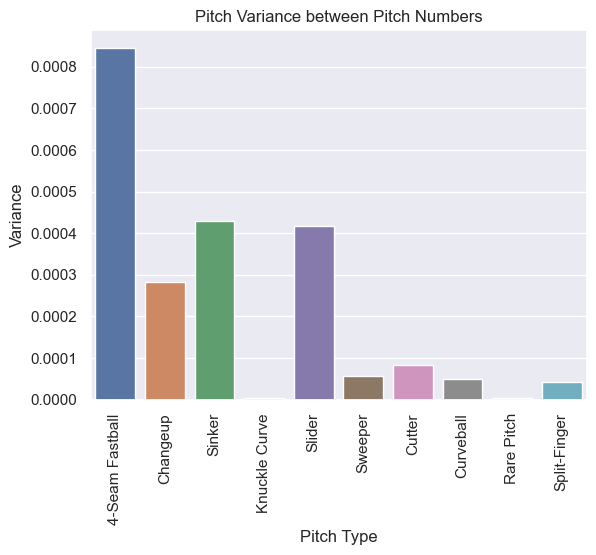

In [180]:
variance_barplot = sns.barplot(data=variance_df)
variance_barplot.set(title='Pitch Variance between Pitch Numbers', xlabel='Pitch Type', ylabel='Variance')
plt.xticks(rotation=90)
plt.show()

____________________________________________________

### 5. Show That the Probability of a Pitch's Use is Consistant Among Pitch Numbers
   - This will be done by conducting a chi square test on each of the pitch types, as well as the entire data set, with a confidence level of 0.05.
     - I will be calculating the test statistics manually, but I have included a package from scipy.stats to check my method with. I will run a test on one column with both the package and manual calculations before scaling it to the data set. I will not be using the package for the entire data set as its results with 2-way classification did not add up in previous tests.
     - I will be using the observed and expected values as calculated above when reclassifying my pitches and pitch numbers
    


First, it will be good to make sure that both the observed and expected sums add together to the same value before running a chi-square test. This is necessary since rounding was used.

In [184]:
for name in pitch_names:
    print(f'Observed {name} sum: {obs_pitch_df[name].sum()}\nExpected {name} sum: {exp_pitch_df[name].sum()}\nDifference: {obs_pitch_df[name].sum() - exp_pitch_df[name].sum()}\n')

Observed 4-Seam Fastball sum: 108346
Expected 4-Seam Fastball sum: 108346.0
Difference: 0.0

Observed Changeup sum: 35317
Expected Changeup sum: 35317.0
Difference: 0.0

Observed Sinker sum: 55770
Expected Sinker sum: 55770.00000000001
Difference: -7.275957614183426e-12

Observed Knuckle Curve sum: 5524
Expected Knuckle Curve sum: 5523.999999999999
Difference: 9.094947017729282e-13

Observed Slider sum: 57024
Expected Slider sum: 57023.99999999999
Difference: 7.275957614183426e-12

Observed Sweeper sum: 20013
Expected Sweeper sum: 20013.0
Difference: 0.0

Observed Cutter sum: 28199
Expected Cutter sum: 28199.000000000007
Difference: -7.275957614183426e-12

Observed Curveball sum: 22573
Expected Curveball sum: 22572.999999999996
Difference: 3.637978807091713e-12

Observed Rare Pitch sum: 2314
Expected Rare Pitch sum: 2313.9999999999995
Difference: 4.547473508864641e-13

Observed Split-Finger sum: 10920
Expected Split-Finger sum: 10919.999999999996
Difference: 3.637978807091713e-12



All of the differences are practically zero. The small difference gotten from rounding is small enough to be acceptable. 


The cell below is a test of the method that will be used for the entire data set. The test statistics match, so the method will be expanded.


In [186]:
fastball_obs = obs_pitch_df[['4-Seam Fastball']]
fastball_exp = exp_pitch_df[['4-Seam Fastball']]

chi_sum2 = 0  #stores the sum for the test statistic
for num in pitch_nums:   #chi-square summation
    chi_sum2 += (((fastball_obs.loc[num, '4-Seam Fastball'])-(fastball_exp.loc[num, '4-Seam Fastball']))**2)/(fastball_exp.loc[num, '4-Seam Fastball'])

#Calculation done with package for redundance
package_calc = chisquare(np.array(obs_pitch_df['4-Seam Fastball']), f_exp=np.array(exp_pitch_df['4-Seam Fastball']))

print(f'Manually calculated test statistic is {chi_sum2}\n',
      f'Package Calculated test statistic is {package_calc[0]}\n',
      f'The package gives a p-value of {package_calc[1]}')

Manually calculated test statistic is 344.8876384925032
 Package Calculated test statistic is 344.8876384925032
 The package gives a p-value of 4.842974868056521e-68


Below, this will output the chi-square statistic for each pitch type along with its degree of freedom, followed by the statistic for the entire dataframe.

In [188]:
chi_sum_entire = 0  #stores sum for the test statistic of the entire data frame

for name in pitch_names:
    pitch_name_chi = 0  #sum for test statistic of pitch type
    for num in pitch_nums:
        pitch_difference = ( ((obs_pitch_df.loc[num, name]) - (exp_pitch_df.loc[num, name]))**2 ) / (exp_pitch_df.loc[num, name]) #chi-square summation
        pitch_name_chi += pitch_difference #add to pitch type chi-square
        chi_sum_entire += pitch_difference #add to data set chi-square
    print(f'{name}: {round(pitch_name_chi,3)}, D.F.= 10')

pitch_dof = (len(obs_pitch_df.columns)-1) * (len(obs_pitch_df.index)-1) #get degrees of freedom for dataset using (row-1)(column-1)
print(f'The test statistic for the entire dataset is {round(chi_sum_entire,3)} with a degree of freedom of {pitch_dof}')

4-Seam Fastball: 344.888, D.F.= 10
Changeup: 1799.301, D.F.= 10
Sinker: 831.605, D.F.= 10
Knuckle Curve: 45.69, D.F.= 10
Slider: 58.474, D.F.= 10
Sweeper: 74.041, D.F.= 10
Cutter: 433.065, D.F.= 10
Curveball: 332.396, D.F.= 10
Rare Pitch: 24.985, D.F.= 10
Split-Finger: 915.725, D.F.= 10
The test statistic for the entire dataset is 4860.17 with a degree of freedom of 90


### As of this point, I am seeing strong evidence that pitch type and pitch number are dependant on each other. That also holds true for each pitch type on its own, Though I have some doubts about that p-value and I will need to make sure the calculations were done accurately

____________________________________________________

## Goal: Filter to only the frequent batters

### 1. player_name is the name of the _batter_. We create a new dataframe with just the batter and game information to make parsing faster

In [193]:
bdf_batters = bdf[['player_name','batter','game_pk','at_bat_number']]

### 2. Create a dataframe that has each player with their corresponding ID and an empty column for average plate appearance per game. then create a list of all unique player ids to iterate through.

In [195]:
bdf_players = bdf[['player_name','batter']].drop_duplicates(subset='batter') #create dataframe with player name and id, with each player appearing once
bdf_players['avg_plate_app'] = pd.Series()   #add empty column to contain a players average plate appearances per game
player_ids = list(bdf_players['batter'].unique()) #list of all unique player ids
bdf_players.head()

,player_name,batter,avg_plate_app
0,"Rocchio, Brayan",677587,NaN
3,"Ohtani, Shohei",660271,NaN
4,"Hedges, Austin",595978,NaN
5,"Casas, Triston",671213,NaN
6,"Rizzo, Anthony",519203,NaN


### 3. Create dataframe with only unique plate appearances. this removes entries for subsequent pitches in the same plate appearance

In [197]:
bdf_plateapp = bdf_batters.drop_duplicates(subset=['game_pk','at_bat_number'], keep='first') 

### 4. Update the avg_plate_app with the average plate appearances per player than check if any player was missed

In [199]:
for id in player_ids: #find count of plate appearances and total games for a player, then divide appearance by total games for their average.
    plateapp = len(bdf_plateapp[bdf_plateapp['batter']==id])
    tot_games = len(bdf_plateapp[bdf_plateapp['batter']==id]['game_pk'].unique())
    bdf_players.loc[bdf_players.index[bdf_players['batter']==id], 'avg_plate_app'] = plateapp/tot_games #update dataframe with calculated average

bdf_players.isna().sum() #confirm all players have an corresponding average plate appearance

player_name      0
batter           0
avg_plate_app    0
dtype: int64

In [200]:
bdf_players.head()

,player_name,batter,avg_plate_app
0,"Rocchio, Brayan",677587,3.523077
3,"Ohtani, Shohei",660271,4.52
4,"Hedges, Austin",595978,3.0
5,"Casas, Triston",671213,3.941176
6,"Rizzo, Anthony",519203,4.138462


In [201]:
print('There are ' + str(len(bdf_players.query('avg_plate_app >= 3.1'))) + ' with over 3.1 average plate appearances per game')
print('Total Players Found: ' + str(len(bdf_players)))

There are 406 with over 3.1 average plate appearances per game
Total Players Found: 559


## Out of all 559 players, 406 were found to meet our requirements of being a frequent batter. This list can be used later in the project to gauge behaviors and swing characteristics of the usual batters, which can then be compared to any potential changes in how a pitcher throws.